Importing all the Dependencies

In [ ]:
import tensorflow as tf
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np

## Loading Dataset from google drive(Dataset is taken from kaggle website)

Dataset credits: https://www.kaggle.com/arjuntejaswi/plant-village



In [4]:
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
image_size = 256
batch = 32
RGB = 3

Import data into tensorflow dataset object.
We will use image_dataset_from_directory api to load all images in tensorflow dataset: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory

In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Plant Data',batch_size=batch,
    image_size=(image_size,image_size), shuffle=True
    )

Found 2152 files belonging to 3 classes.


In [7]:
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

## Data Visualization

In [8]:
for image_batch,image_labels in dataset.take(1):
  print(image_batch.shape)
  print(image_labels.numpy())

(32, 256, 256, 3)
[0 0 0 0 1 0 1 0 1 1 0 1 1 1 1 1 1 0 0 2 1 0 0 0 1 1 1 1 2 1 1 1]


Each element in the dataset is a tuple, as we can see above. The first component is a batch of 32 picture elements. The second component is a set of 32 class label components.

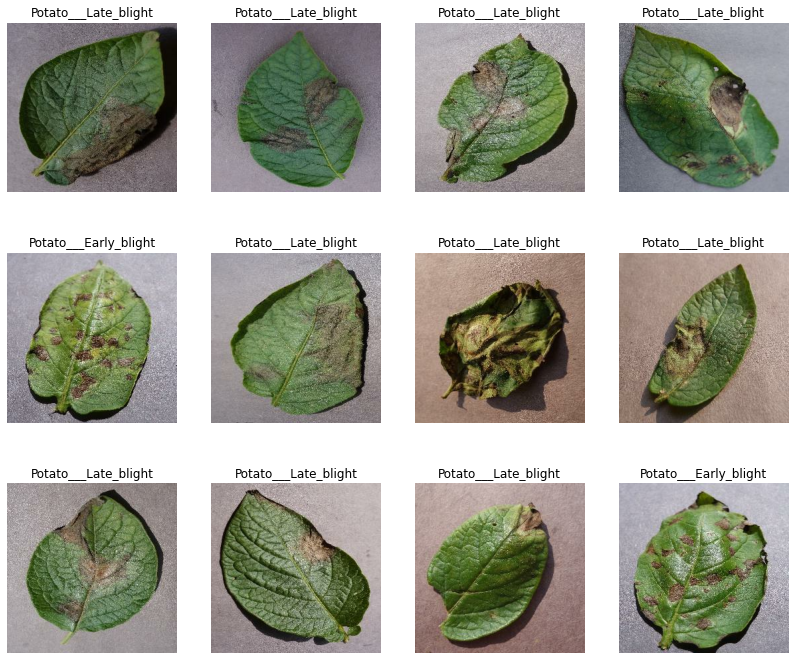

In [9]:
plt.figure(figsize=(14,12))

for image_batch,image_labels in dataset.take(1):
  for i in range(12):
    ax= plt.subplot(3,4, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_name[image_labels[i]])
    plt.axis('off')

In [10]:
int(len(dataset)*0.8)

54

In [11]:
len(dataset.skip(10))

58

In [12]:
int(len(dataset)*0.1)

6

## Split Dataset Function 

The dataset should be divided into three parts: 

Validation: Dataset to be tested against while training Training: Dataset to be used while training 
After we've trained a model, we'll test it against a data set.

In [13]:
def Train_test_validation(dataset,shuffle=True,shuffle_size=10000):
  train_size = int(len(dataset)*0.8)
  train = dataset.take(train_size)
  test_val = dataset.skip(train_size)
  val_size = int(len(dataset)*0.1)
  validation = test_val.take(val_size)
  test = test_val.skip(val_size)
  return train, test, validation

In [14]:
train,test,validation = Train_test_validation(dataset)

## Cache, Shuffle, and Prefetch the Dataset: 
These are inbuilt fuction in the tensorflow that makes us to fasten the training time of the model

In [15]:
train = train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation = validation.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model
## Creating a Layer for Resizing and Normalization

We should resize our images to the proper size before uploading them to the network. Furthermore, we should normalise the image pixel value to boost model performance (keeping them in range 0 and 1 by dividing by 256). This should happen during both training and inference. As a result, we may include it as a layer in our Sequential Model.

In [16]:
from tensorflow.keras import models, layers

In [17]:
Resizing_rescaling = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(256,256),
    layers.experimental.preprocessing.Rescaling(1.0/255),

])

# Data Augmentation

When we have fewer data, we need to use data augmentation. This improves the accuracy of our model by augmenting the data.

In [18]:
Data_augumentation = tf.keras.Sequential([
        layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
        layers.experimental.preprocessing.RandomRotation(0.2)
])

In [19]:
train = train.map(
    lambda x, y: (Data_augumentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [20]:
input_shape = (batch, image_size, image_size, RGB)
n_classes = 3

model = models.Sequential([
    Resizing_rescaling,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

## Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [22]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train,
    batch_size=batch,
    validation_data=validation,
    verbose=1,
    epochs=30,
)

Epoch 1/30
54/54 [==============================] - 348s 4s/step - loss: 0.9270 - accuracy: 0.5104 - val_loss: 0.8325 - val_accuracy: 0.5208
Epoch 2/30
54/54 [==============================] - 199s 4s/step - loss: 0.7647 - accuracy: 0.6325 - val_loss: 0.6123 - val_accuracy: 0.7448
Epoch 3/30
54/54 [==============================] - 198s 4s/step - loss: 0.4826 - accuracy: 0.7946 - val_loss: 0.5182 - val_accuracy: 0.7812
Epoch 4/30
54/54 [==============================] - 197s 4s/step - loss: 0.3809 - accuracy: 0.8490 - val_loss: 0.3480 - val_accuracy: 0.8698
Epoch 5/30
54/54 [==============================] - 199s 4s/step - loss: 0.2389 - accuracy: 0.9120 - val_loss: 0.3033 - val_accuracy: 0.8802
Epoch 6/30
54/54 [==============================] - 198s 4s/step - loss: 0.2474 - accuracy: 0.8964 - val_loss: 0.2941 - val_accuracy: 0.8854
Epoch 7/30
54/54 [==============================] - 199s 4s/step - loss: 0.2018 - accuracy: 0.9172 - val_loss: 0.2062 - val_accuracy: 0.9219
Epoch 8/30
54

In [24]:
scores = model.evaluate(test)

8/8 [==============================] - 14s 869ms/step - loss: 0.1073 - accuracy: 0.9698


You can see above that we get $96.98%$ accuracy for our test dataset. This is considered to be a pretty good accuracy

In [25]:
scores

[0.10734957456588745, 0.9698275923728943]

Scores is just a list containing loss and accuracy value

## Plotting the Accuracy and Loss Curves

In [26]:
history

In [27]:
history.params

{'epochs': 30, 'steps': 54, 'verbose': 1}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
type(history.history['loss'])

list

In [30]:
len(history.history['loss'])

30

In [31]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.926990807056427,
 0.7647055387496948,
 0.4825862944126129,
 0.38087785243988037,
 0.23890946805477142]

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [35]:
EPOCHS = 30

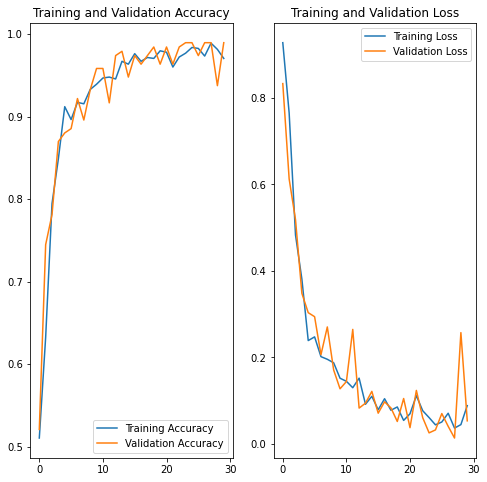

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Run prediction on a sample image

first image to predict
actual label: Potato___Early_blight
predicted label: Potato___Early_blight


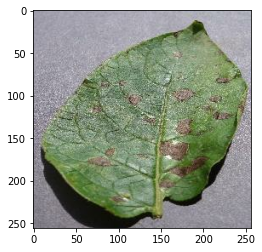

In [37]:
import numpy as np
for images_batch, labels_batch in test.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_name[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_name[np.argmax(batch_prediction[0])])

## Write a function for inference

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Now run inference on few sample images

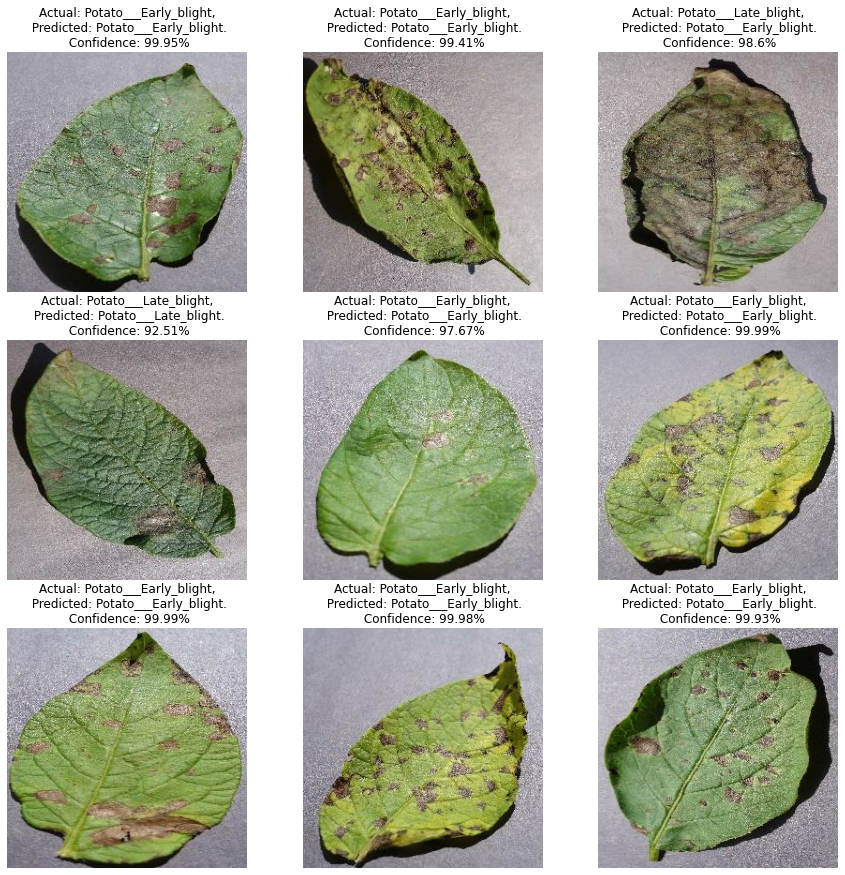

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

## Saving the Model

In [40]:
model.save("Final_model")

INFO:tensorflow:Assets written to: Final_model/assets
